# Analysis

## 1. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import classification_report

sp = spacy.load('en_core_web_sm')

%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("notebook")

plt.rcParams['figure.figsize'] = [10, 7]

### Import dataset

In [22]:
data = pd.read_csv("../data/extremely_clean_dataset.csv") 

# Keep the first 1000 elements to reduce the load on cpu
data_debug = data[:50000]
data.head()

,review,sentiment
0,reviewer mention watch episode hook right exac...,positive
1,wonderful little production technique very una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy think zombie close...,negative
4,petter love time money visually stunning film ...,positive


## 2. EDA

In [3]:
data.describe()

,review,sentiment
count,50000,50000
unique,49569,2
top,love variety not solely cook great very captiv...,positive
freq,5,25000


In [4]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
base_rate = max(data['sentiment'].value_counts()) / data.shape[0]
print("Base rate: {}".format(base_rate))

Base rate: 0.5


## 3. Analysis

#### Tokenizer

In [6]:
nlp = spacy.lang.en.English()

def tokenize_review(this_review):
    return [token.text for token in nlp(this_review)]

#### Prepare Test Sets

In [23]:
# Bag of words representation using CountVectorizer
count_vector = CountVectorizer(tokenizer = tokenize_review, ngram_range = (1,2))

X = count_vector.fit_transform(data_debug['review'])
y = data_debug['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

#### Helper functions

In [8]:
def confusion_matrix(classifier, X_test, y_test):
    sns.set_style("white")
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
        disp.ax_.set_title(title)
    
    sns.set_style("darkgrid")

###  3.1 KNN Classification

Explain KNN 

#### Tuning the value of n

First, we whan to find the optimal value of N for our data

In [9]:
scores = {}
for n in range(1, 71):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    scores[n] = knn.score(X_test, y_test)

Text(0.5, 0, 'N')

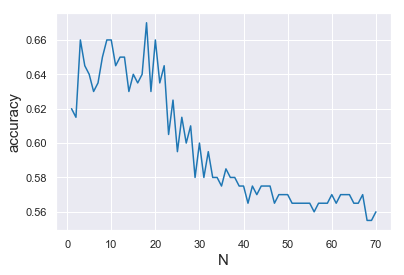

In [10]:
plt.plot([key for key in scores.keys()], [value for value in scores.values()])
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('N', fontsize=15)

In [11]:
best_n = max(scores, key=scores.get)
print("Number of neighbours giving the highest accuracy: {}, Accuracy: {}".format(best_n, scores[best_n]))

Number of neighbours giving the highest accuracy: 18, Accuracy: 0.67


#### Complete KNN model

In [12]:
knn = KNeighborsClassifier(n_neighbors=best_n)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=18, p=2,
                     weights='uniform')

In [13]:
knn.score(X_test, y_test)

0.67

##### Classification report

In [14]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

    negative       0.83      0.41      0.55        98
    positive       0.62      0.92      0.74       102

    accuracy                           0.67       200
   macro avg       0.73      0.66      0.64       200
weighted avg       0.72      0.67      0.65       200



##### Confusion matrix

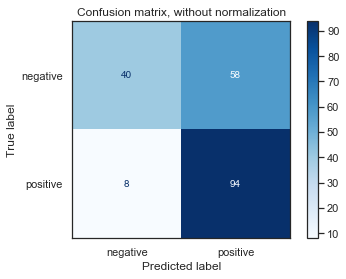

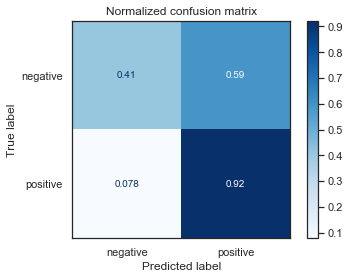

In [15]:
confusion_matrix(knn, X_test, y_test)

##### Precision - Recall 

In [29]:
#y_score = knn.predict(X_test)

#average_precision = average_precision_score(y_test, y_score, pos_label="positive")

#print('Average precision-recall score: {0:0.2f}'.format(
#      average_precision))

#disp = plot_precision_recall_curve(knn, X_test, y_test)
#disp.ax_.set_title('2-class Precision-Recall curve: '
#                  'AP={0:0.2f}'.format(average_precision))

### 3.2 Decision Trees

#### Tuning the depth of the tree

In [44]:
scores = {}
for d in range(1, 21):
    tree = DecisionTreeClassifier(max_depth=d)
    tree.fit(X_train, y_train)
    scores[d] = tree.score(X_test, y_test)

Text(0.5, 0, 'Depth')

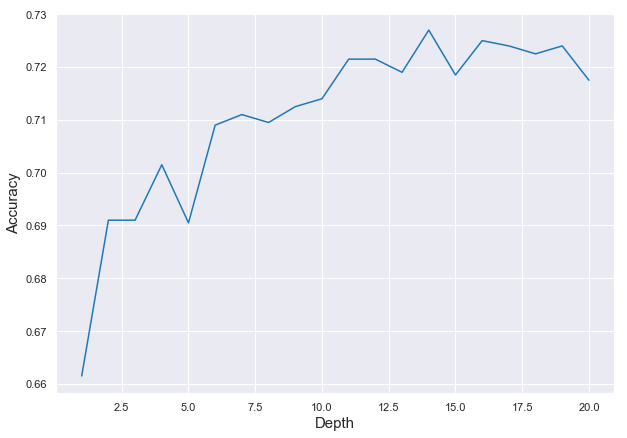

In [45]:
plt.plot([key for key in scores.keys()], [value for value in scores.values()])
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Depth', fontsize=15)

In [46]:
best_d = max(scores, key=scores.get)
print("Max depth giving the highest accuracy: {}, Accuracy: {}".format(best_d, scores[best_d]))

Max depth giving the highest accuracy: 14, Accuracy: 0.727


#### Complete Decision Tree model

In [24]:
#tree = DecisionTreeClassifier(max_depth=best_d)
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [25]:
tree.score(X_test,y_test)

0.7079

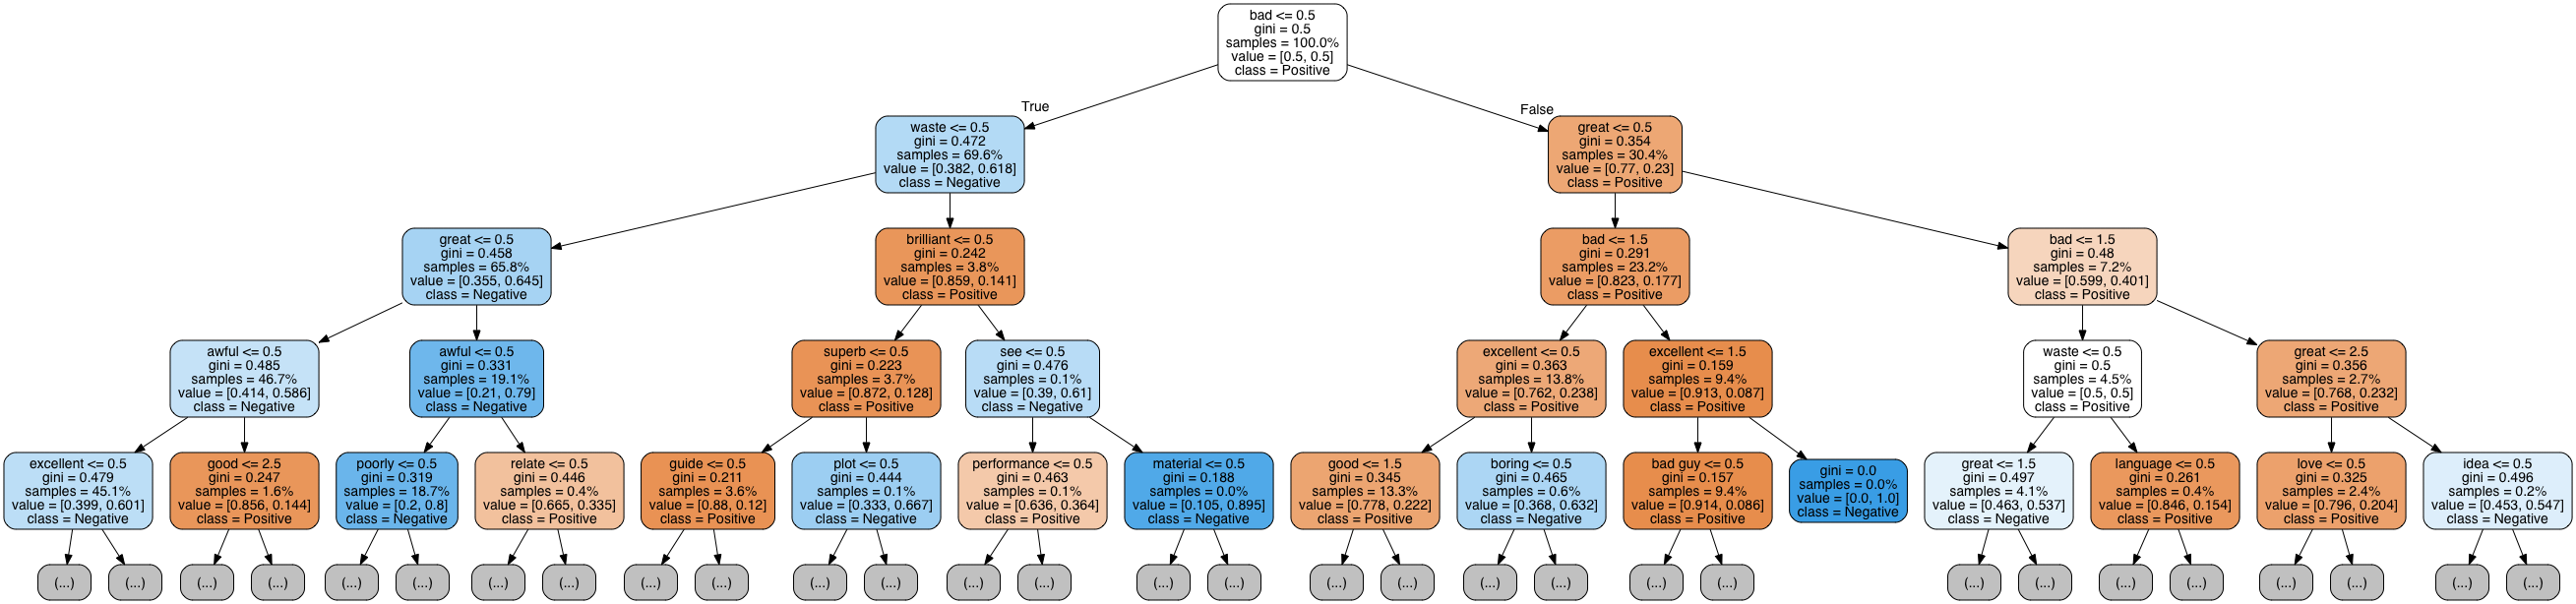

In [30]:
from graphviz import Source

graph = Source(export_graphviz(tree, max_depth = 4, feature_names=count_vector.get_feature_names(), class_names = ['Positive', 'Negative'], proportion=True, filled=True, rounded=True))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

##### Classificaiton report

In [39]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

    negative       0.84      0.58      0.69        98
    positive       0.69      0.89      0.78       102

    accuracy                           0.74       200
   macro avg       0.76      0.74      0.73       200
weighted avg       0.76      0.74      0.73       200



##### Confusion matrix

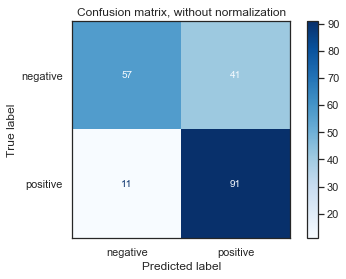

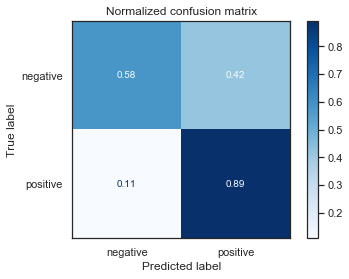

In [40]:
confusion_matrix(tree, X_test, y_test)

### 3.3 Logistic Model

In [ ]:
# We're looking for the value C that gives the highest accuracy

accuracy_by_c = []
for C in [0.01, 0.05, 0.25, 0.5, 1]:
    classifier = LogisticRegression(solver="saga", max_iter=2000, C=C)

    # Create pipeline using Bag of Words
    pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

    # Fit Model
    pipe.fit(X_train,y_train)

    accuracy = pipe.score(X_test, y_test)
    print("Accuracy for C={}: {}".format(C, accuracy))
    accuracy_by_c.append({'c': c, 'accuracy': accuracy})

In [ ]:
plt.plot([point['c'] for point in accuracy_by_c], [point['accuracy'] for point in accuracy_by_c])

0.25 is highest, perform logistic regression on whole dataset

In [ ]:
X = data['review'] 
y = data['sentiment'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

# Notes: - saga is better than lbfgs for large datasets
#        - at default max_iter (1000) the model doesn't converge, 2000 works
classifier = LogisticRegression(solver="lbfgs", C=0.25, max_iter=2000)

count_vector = CountVectorizer(tokenizer = tokenize_review, ngram_range = (1, 2))

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

# Fit Model
pipe.fit(X_train,y_train)

pipe.score(X_test, y_test)

#### Logistic Regression using TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer = tokenize_review, ngram_range = (1, 2))
pipe = Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', classifier)])

pipe.fit(X_train,y_train)
pipe.score(X_test, y_test)

#### Logistic Regression using SVM


In [ ]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(C=0.25, max_iter=2000)
count_vector = CountVectorizer(tokenizer = tokenize_review, ngram_range = (1, 2))

pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

pipe.fit(X_train,y_train)
pipe.score(X_test, y_test)

### Strongest Coefficients

In [ ]:
def get_interesting_features(features):
    interesting_coefs = []
    for best_positive in sorted(features.items(), key=lambda x: x[1], reverse=True)[:5]:
        interesting_coefs.append(best_positive)

    for best_negative in sorted(features.items(), key=lambda x: x[1])[:5]:
        interesting_coefs.append(best_negative)
    return interesting_coefs

In [ ]:
def graph_interesting_features(interesting_features):
    sorted_by_coef = sorted(interesting_features, key=lambda tup: tup[1], reverse=True)

    feature = [elem[0] for elem in sorted_by_coef]
    coef = [elem[1] for elem in sorted_by_coef]

    plt.bar(feature, coef)
    plt.xticks(feature, fontsize=12)
    plt.xticks(rotation=30)
    plt.show()

In [ ]:
model_features = {
    word: coef for word, coef in zip(
        count_vector.get_feature_names(), classifier.coef_[0]
    )
}

interesting_features = get_interesting_features(model_features)
graph_interesting_features(interesting_features)

In [ ]:
two_gram_features = {key: model_features[key] for key in model_features.keys() if len(key.split(' ')) == 2}
intersting_features = get_interesting_features(two_gram_features)
graph_interesting_features(intersting_features)

#### Results

In [ ]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = pipe.predict(X_test)
print(classification_report(y_test, target_pred))

#### Confusion matrix

In [ ]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

#### Precision Recall Curve


In [ ]:
y_score = pipe.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score, pos_label="positive")

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(pipe, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# 2.3. Conclusion and Recommendation

From the analysis shown above we can see that the best performing method of classification of the reviews into binary class positive/negative is Logistic Regression method......